<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

device = "cuda" if torch.cuda.is_available() else "cpu"



# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

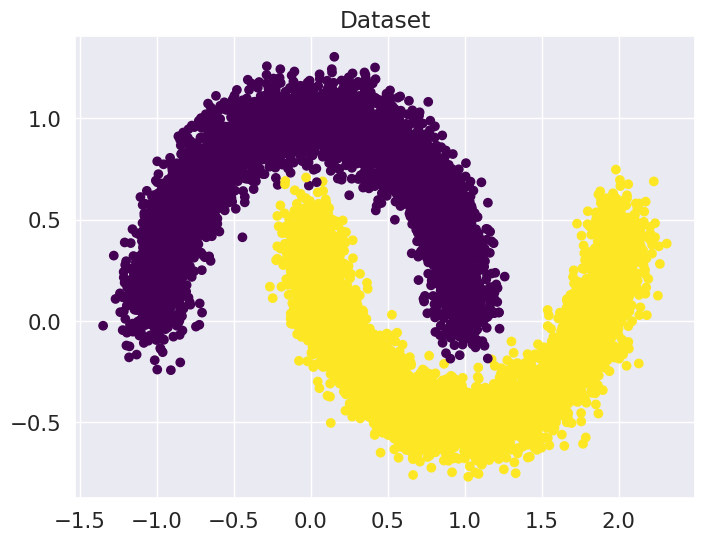

In [3]:
plt.figure(figsize=(8, 6))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.from_numpy(X_train).type_as(torch.FloatTensor())
y_train_t =  torch.from_numpy(y_train).type_as(torch.FloatTensor())
X_val_t =  torch.from_numpy(X_val).type_as(torch.FloatTensor())
y_val_t =  torch.from_numpy(y_val).type_as(torch.FloatTensor())

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
import torch
import torch.nn as nn

class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))  # Initialize weights
        self.bias = nn.Parameter(torch.randn(out_features)) if bias else None  # Initialize bias if bias=True

    def forward(self, x):
        logits = x @ self.weights.t()  # Matrix multiplication XW
        if self.bias is not None:
            logits += self.bias.unsqueeze(0)  # Add bias term
        return logits

In [16]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [9]:
(2+1)*(1)

3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [17]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)  # Use linear_regression to get outputs
        loss = loss_function(outp, y_batch.unsqueeze(1))  # Compute loss
        loss.backward()
        losses.append(loss.detach().item())
        optimizer.step()
        probabilities = torch.sigmoid(outp)  # Compute probabilities using sigmoid function
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")

        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}. Convergence. Stopping iterations.")
            stop_it = True
            break

        prev_weights = current_weights

    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.5546875
Iteration: 200
Batch accuracy: 0.7265625
Iteration: 300
Batch accuracy: 0.828125
Iteration: 400
Batch accuracy: 0.8046875
Iteration: 500
Batch accuracy: 0.875
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.796875
Iteration: 800
Batch accuracy: 0.8125
Iteration: 900
Batch accuracy: 0.8203125

Iteration: 936. Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

### Визуализируем результаты

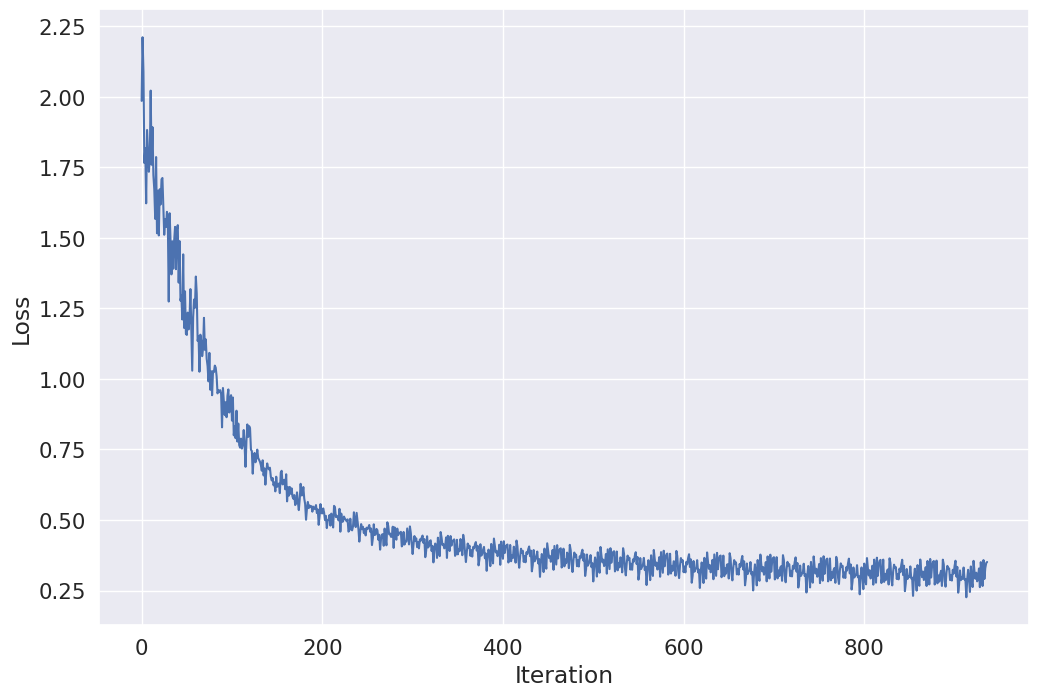

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

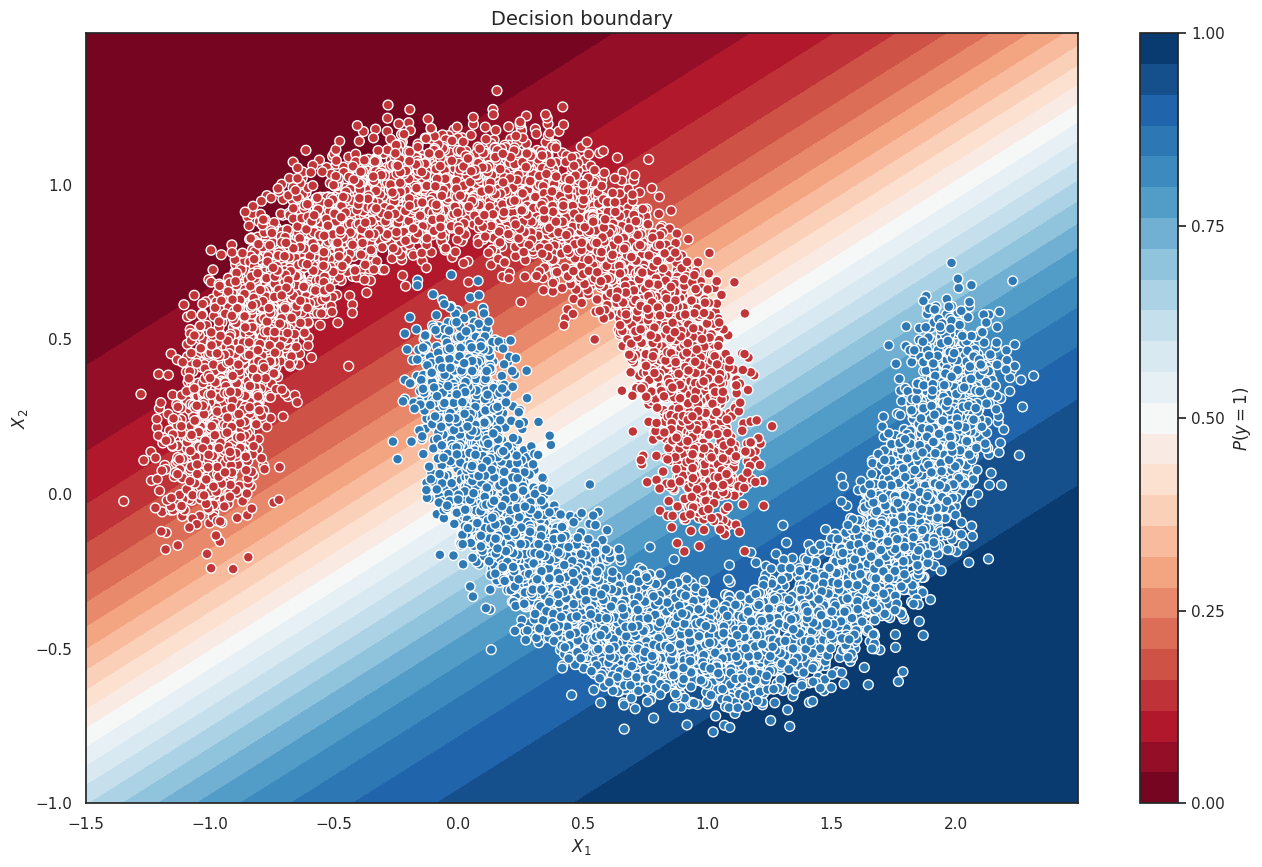

In [19]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [20]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    true_labels = np.array([])
    for x_batch, y_batch in dataloader:
        outputs = model(x_batch)
        preds = (torch.sigmoid(outputs) > 0.5).type(torch.float32)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
        true_labels = np.hstack((true_labels, y_batch.numpy().flatten()))
    return predictions.flatten(), true_labels

In [21]:
from sklearn.metrics import accuracy_score

# Call the predict function on the test dataloader
predicted_labels, true_labels = predict(val_dataloader, linear_regression)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy on the test set: {accuracy}")

Accuracy on the test set: 0.8596


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**

0.8768

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [12]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, drop_last=True)
valid_dataloader = DataLoader(val_dataset, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 121907176.92it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19585399.16it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35521121.93it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21073593.77it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [13]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).

In [14]:
# Define the activation function
activation = nn.ELU()

# Create the neural network model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=128),  # First hidden layer with 128 neurons
    activation,
    nn.Linear(in_features=128, out_features=128),     # Second hidden layer with 128 neurons
    activation,
    nn.Linear(in_features=128, out_features=10)       # Output layer with 10 neurons for classification
)
model.to(device)

# Define the loss function (Cross Entropy Loss for classification)
loss_function = nn.CrossEntropyLoss()


In [15]:
# Select the Cross-Entropy loss function
criterion = nn.CrossEntropyLoss()

# Define the Adam optimizer to update model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create a dictionary of data loaders for training and validation sets
loaders = {"train": train_dataloader, "valid": valid_dataloader}


### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [16]:
max_epochs = 5
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0

        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()  # Set model to train mode
                optimizer.zero_grad()  # Clear gradients
                outp = model(x_batch)  # Calculate outputs
            else:
                model.eval()  # Set model to evaluation mode
                with torch.no_grad():
                    outp = model(x_batch)  # Calculate outputs

            preds = outp.argmax(dim=1)
            correct = (preds == y_batch).sum().item()
            all = y_batch.size(0)

            epoch_correct += correct
            epoch_all += all

            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()  # Calculate gradients
                optimizer.step()  # Update weights

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8911666666666667
Loader: valid. Accuracy: 0.8939
Epoch: 2
Loader: train. Accuracy: 0.92995
Loader: valid. Accuracy: 0.9289
Epoch: 3
Loader: train. Accuracy: 0.9383
Loader: valid. Accuracy: 0.8932
Epoch: 4
Loader: train. Accuracy: 0.9441333333333334
Loader: valid. Accuracy: 0.9338
Epoch: 5
Loader: train. Accuracy: 0.9472833333333334
Loader: valid. Accuracy: 0.9246


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [17]:
elu_accuracy = accuracy["valid"]

In [18]:
def test_activation_function(activation):
    accuracies = []
    for activation_func in activation:
        model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            activation_func(),
            nn.Linear(128, 128),
            activation_func(),
            nn.Linear(128, 10)
        )
        model.to(device)  # Move the model to the specified device

        optimizer = torch.optim.Adam(model.parameters())

        accuracy = {"train": [], "valid": []}
        for epoch in range(max_epochs):
            for k, dataloader in loaders.items():
                epoch_correct = 0
                epoch_all = 0

                for x_batch, y_batch in dataloader:
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    if k == "train":
                        model.train()
                        optimizer.zero_grad()
                        outp = model(x_batch)
                    else:
                        model.eval()
                        with torch.no_grad():
                            outp = model(x_batch)

                    preds = outp.argmax(dim=1)
                    correct = (preds == y_batch).sum().item()
                    all = y_batch.size(0)

                    epoch_correct += correct
                    epoch_all += all

                    if k == "train":
                        loss = criterion(outp, y_batch)
                        loss.backward()
                        optimizer.step()

                if k == "train":
                    print(f"Epoch: {epoch+1}")
                print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
                accuracy[k].append(epoch_correct / epoch_all)

        accuracies.append(accuracy["valid"])

    return accuracies

# Define different activation functions to test
activation_functions = [nn.ReLU, nn.LeakyReLU]

# Test different activation functions
accuracies = test_activation_function(activation_functions)

# Access the accuracies for each activation function
#elu_accuracy = accuracies[0]
relu_accuracy = accuracies[0]
leaky_relu_accuracy = accuracies[1]

Epoch: 1
Loader: train. Accuracy: 0.8889166666666667
Loader: valid. Accuracy: 0.8845
Epoch: 2
Loader: train. Accuracy: 0.91855
Loader: valid. Accuracy: 0.8935
Epoch: 3
Loader: train. Accuracy: 0.9214166666666667
Loader: valid. Accuracy: 0.8832
Epoch: 4
Loader: train. Accuracy: 0.9245833333333333
Loader: valid. Accuracy: 0.8713
Epoch: 5
Loader: train. Accuracy: 0.9259333333333334
Loader: valid. Accuracy: 0.891
Epoch: 1
Loader: train. Accuracy: 0.8896666666666667
Loader: valid. Accuracy: 0.8936
Epoch: 2
Loader: train. Accuracy: 0.9206
Loader: valid. Accuracy: 0.9095
Epoch: 3
Loader: train. Accuracy: 0.9273166666666667
Loader: valid. Accuracy: 0.911
Epoch: 4
Loader: train. Accuracy: 0.93245
Loader: valid. Accuracy: 0.9353
Epoch: 5
Loader: train. Accuracy: 0.9364833333333333
Loader: valid. Accuracy: 0.9212


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

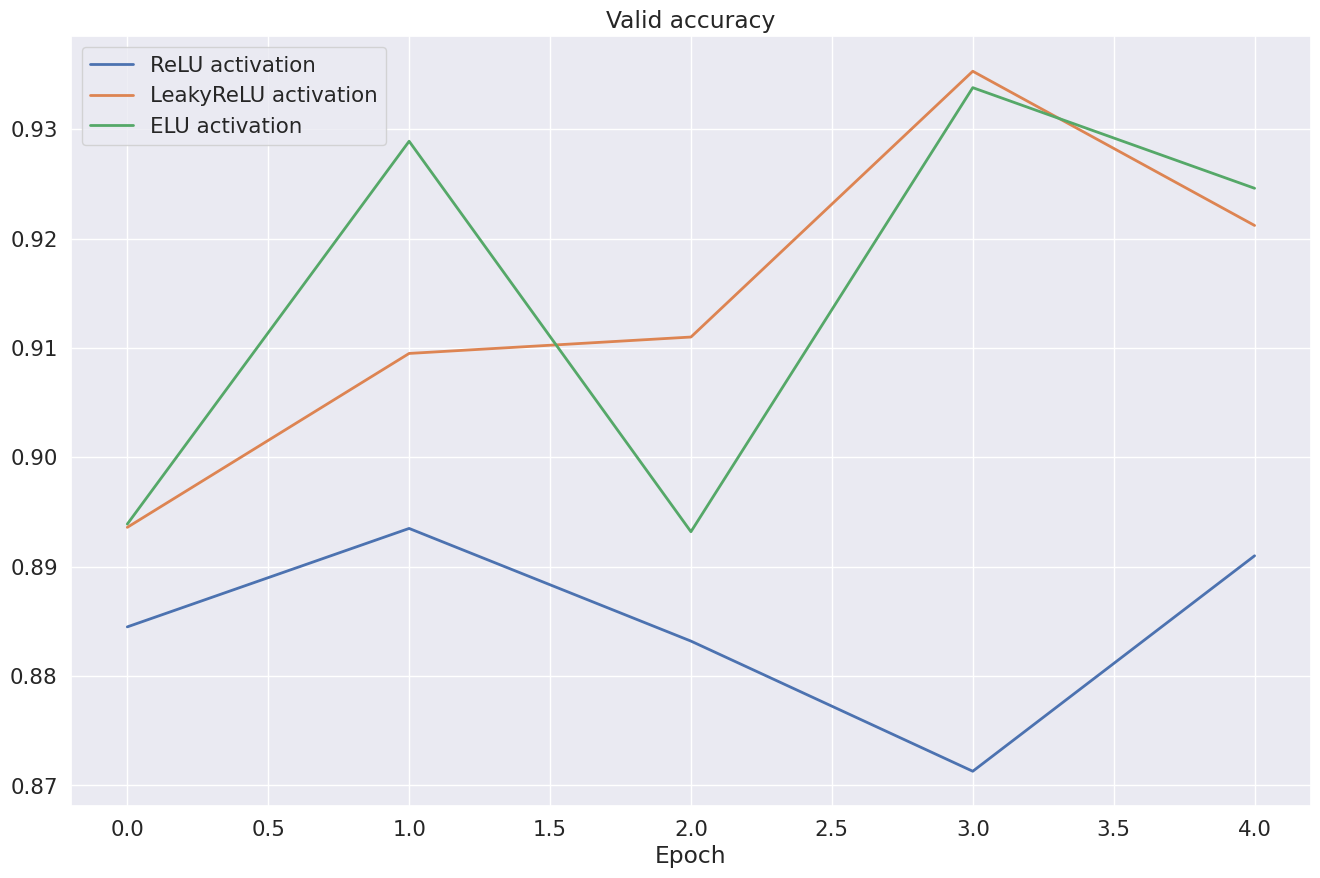

In [20]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
#plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [22]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-02-18 14:31:46--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
ERROR: cannot verify img.the-village.kz's certificate, issued by ‘CN=R3,O=Let's Encrypt,C=US’:
  Issued certificate has expired.
To connect to img.the-village.kz insecurely, use `--no-check-certificate'.


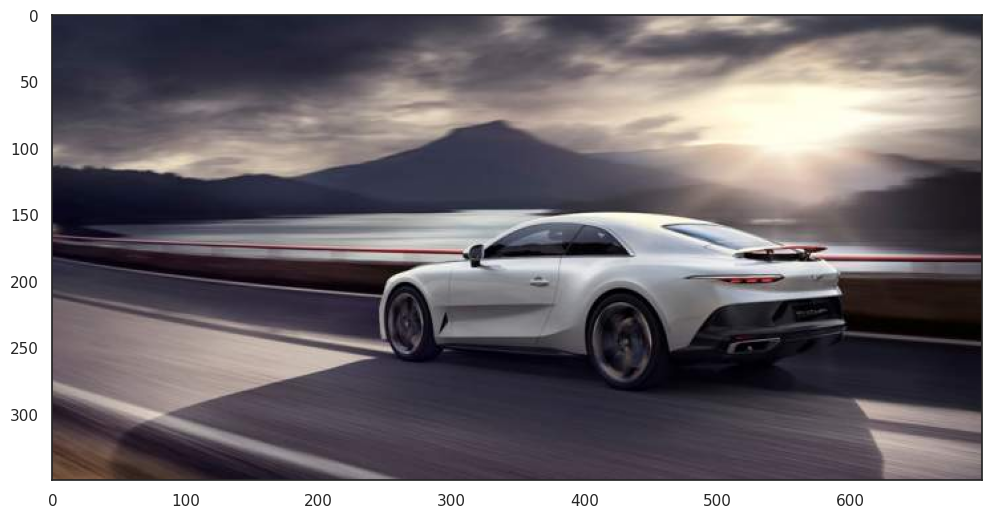

In [30]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_image.jpg")
if img is not None:
    # Convert BGR image to RGB
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(RGB_img)
    plt.show()
else:
    print("Error: Image not loaded or empty.")


Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [33]:
kernel1 = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel2 = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel3 = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel4 = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel5 = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel6 = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernels = [kernel1, kernel2, kernel3, kernel4, kernel5, kernel6]

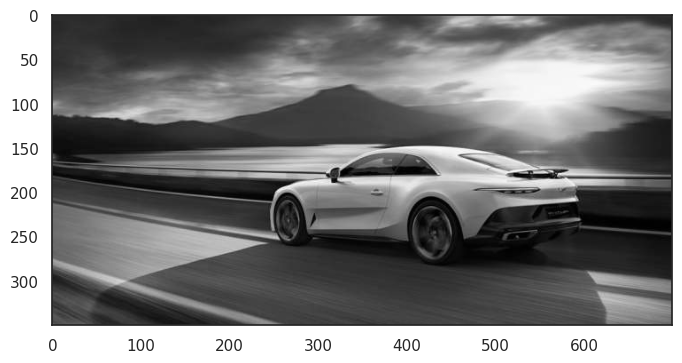

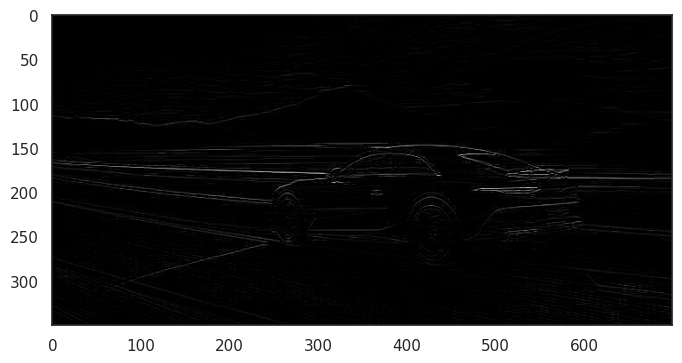

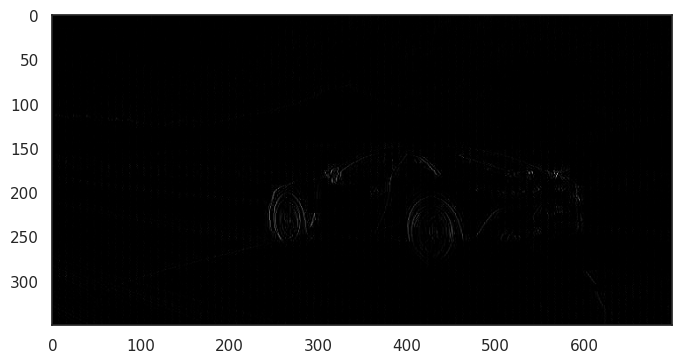

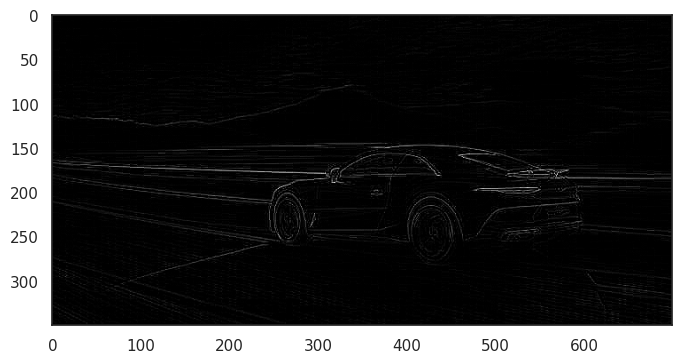

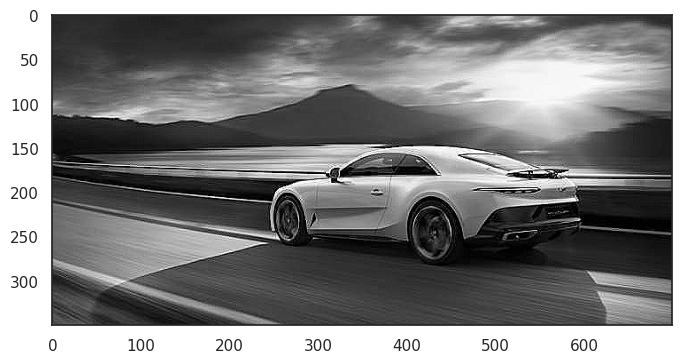

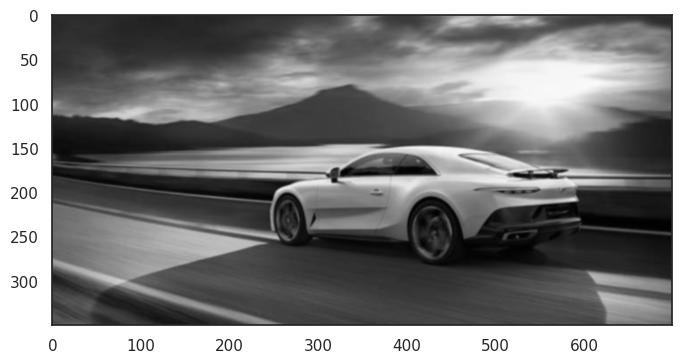

In [35]:
#img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
for kernel in kernels:
    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]  #

    plt.figure(figsize=(8, 6))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    plt.imshow(result_np)
    plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - А

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [36]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [37]:
# Create an instance of LeNet and move it to the GPU
model = LeNet().to(device)

# Define the loss function and move it to the GPU
criterion = nn.CrossEntropyLoss().to(device)

# Define the optimizer and move it to the GPU
optimizer = torch.optim.Adam(model.parameters())

# Assuming train_dataloader and valid_dataloader are already defined
loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [38]:
# Training loop for the CNN model
max_epochs = 5
lenet_accuracy = []

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to the GPU

            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)

            preds = outp.argmax(dim=1)
            correct = (preds == y_batch).sum().item()
            all = y_batch.size(0)

            epoch_correct += correct
            epoch_all += all

            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")

        if k == "valid":
            lenet_accuracy.append(epoch_correct / epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.95755
Loader: valid. Accuracy: 0.9677
Epoch: 2
Loader: train. Accuracy: 0.9777666666666667
Loader: valid. Accuracy: 0.966
Epoch: 3
Loader: train. Accuracy: 0.9803333333333333
Loader: valid. Accuracy: 0.9757
Epoch: 4
Loader: train. Accuracy: 0.9803666666666667
Loader: valid. Accuracy: 0.9775
Epoch: 5
Loader: train. Accuracy: 0.9812
Loader: valid. Accuracy: 0.9745


Сравним с предыдущем пунктом

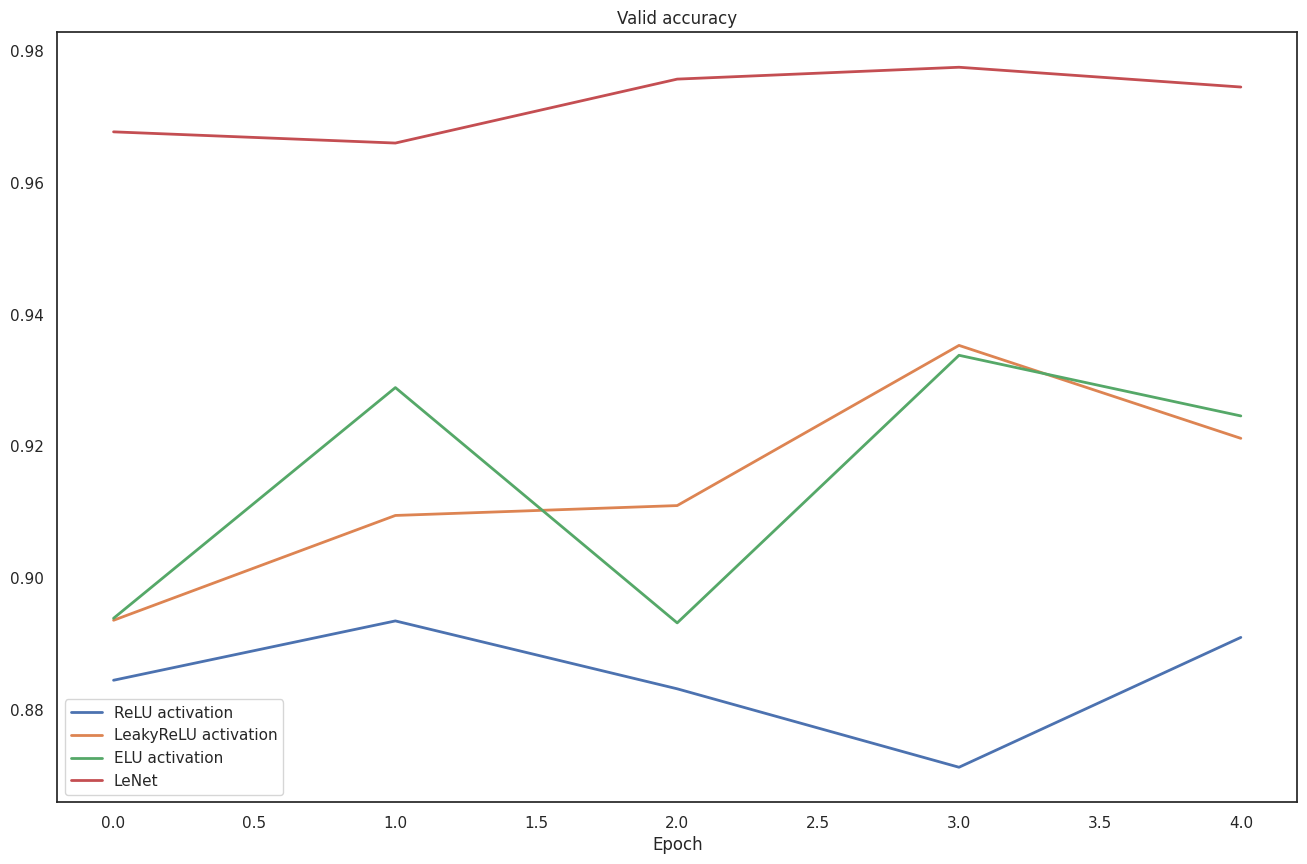

In [39]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.97-0.98
